In [6]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Additional code for data generating processes

## Chapter 09

### Post-training earnings data (simple)

In [39]:
SAMPLE_SIZE = 200
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

took_a_course = stats.bernoulli(p=10/age).rvs().astype(bool)

earnings = 75000 + took_a_course * 10000 + age * 1000 + age**2 * 50 + np.random.randn(SAMPLE_SIZE) * 2000
earnings = earnings.round()

earnings = pd.DataFrame(dict(
    age=age,
    took_a_course=took_a_course,
    earnings=earnings
))

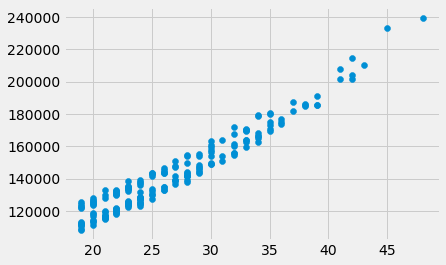

In [40]:
plt.scatter(earnings.age, earnings.earnings)

In [41]:
earnings.to_csv('data/ml_earnings.csv', index=False)

### Post-training earnings data (enhanced)

In [139]:
# Train set large
SAMPLE_SIZE = 5000
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

took_a_course = stats.bernoulli(p=10/age).rvs().astype(bool)
python_proficiency = np.random.uniform(0, 1, SAMPLE_SIZE)

noise = np.random.randn(SAMPLE_SIZE)

earnings = 75000 + took_a_course * 10000 + took_a_course * python_proficiency * 5000 + age * 1000 + age**2 * 50 + noise * 2000
earnings = earnings.round()

earnings = pd.DataFrame(dict(
    age=age,
    python_proficiency = python_proficiency,
    took_a_course=took_a_course,
    earnings=earnings
))

In [140]:
earnings.to_csv('data/ml_earnings_interaction_train.csv', index=False)

In [143]:
# Test set
SAMPLE_SIZE = 100
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

python_proficiency = np.random.uniform(0, 1, SAMPLE_SIZE)

noise = np.random.randn(SAMPLE_SIZE)

earnings_0 = (75000 + 0 * 10000 + 0 * python_proficiency * 5000 + age * 5000 + age**2 * 50 + noise * 2000).round()
earnings_1 = (75000 + 1 * 10000 + 1 * python_proficiency * 5000 + age * 5000 + age**2 * 50 + noise * 2000).round()
true_effect = earnings_1 - earnings_0

earnings_test = pd.DataFrame(dict(
    age=age,
    python_proficiency=python_proficiency,
    took_a_course=True,
    true_effect=true_effect
))

In [144]:
earnings_test.to_csv('data/ml_earnings_interaction_test.csv', index=False)